In [579]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

In [580]:
#extract processed data
df = pd.read_csv("processed_data.csv")

#remove extreme high correlation varaibles and unrelated variables 
df.drop(['ANNMILES', 'GASUSGE'], axis=1, inplace=True)

#separate prediction variable and id from dataframe
df_y = df.pop('SuperUser')
id = df.pop("HOUSEID")

#create train and test dataset
x_train, x_test, y_train, y_test = train_test_split(df, df_y, test_size=0.2)


In [581]:
df

HighestEDUC  TAXISERVICE  RIDESHARE22  ESCOOTERUSED    PTUSED  \
0               7    -0.146325    -0.291888     -0.083774 -0.220185   
1               6    -0.146325    -0.291888     -0.083774 -0.220185   
2               6    -0.146325    -0.291888     -0.083774 -0.220185   
3               6    -0.146325    -0.291888     -0.083774 -0.220185   
4               8    -0.146325     0.745818     -0.083774  1.567999   
...           ...          ...          ...           ...       ...   
7161            7    -0.146325    -0.291888     -0.083774 -0.220185   
7162            7    -0.146325    -0.291888     -0.083774 -0.220185   
7163            6    -0.146325    -0.291888     -0.083774 -0.220185   
7164            2    -0.146325    -0.291888     -0.083774 -0.220185   
7165            4    -0.146325    -0.291888     -0.083774 -0.220185   

      MCTRANSIT  WALKTRANSIT  BIKETRANSIT  EMPLOYMENT2   WTHHFIN  ...  \
0     -0.139403     0.460058     -0.26077     0.437204 -0.673645  ...   
1     -0.139403    -0.013900     -0.26077     0.844070 -0.779578  ...   
2     -0.139403     0.065093     -0.26077     0.030338 -0.372015  ...   
3     -0.139403    -0.566852     -0.26077     0.301582 -0.668265  ...   
4     -0.139403     0.144086     -0.26077     1.115314 -0.500025  ...   
...         ...          ...          ...          ...       ...  ...   
7161  -0.139403    -0.566852     -0.26077    -0.240906 -0.528697  ...   
7162  -0.139403    -0.329873     -0.26077    -1.054638 -0.458785  ...   
7163  -0.139403    -0.566852     -0.26077    -1.054638 -0.799296  ...   
7164  -0.139403    -0.566852     -0.26077    -1.054638 -0.173084  ...   
7165  -0.139403    -0.171887     -0.26077     0.030338 -0.392937  ...   

      SAtlantic  ESCentral  WSCentral  Mountain  Pacific  OneFamDetached  \
0             0          0          0         0        0               1   
1             0          0          0         0        0               0   
2             0          0          0         0        0               0   
3             0          0          0         0        0               0   
4             0          0          0         0        0               1   
...         ...        ...        ...       ...      ...             ...   
7161          0          1          0         0        0               1   
7162          0          1          0         0        0               1   
7163          0          1          0         0        0               1   
7164          0          1          0         0        0               1   
7165          0          1          0         0        0               1   

      OneFamAttached  Apartment  MobileHome  VehicleHome  
0                  0          0           0            0  
1                  0          1           0            0  
2                  0          1           0            0  
3                  1          0           0            0  
4                  0          0           0            0  
...              ...        ...         ...          ...  
7161               0          0           0            0  
7162               0          0           0            0  
7163               0          0           0            0  
7164               0          0           0            0  
7165               0          0           0            0  

[7166 rows x 66 columns]

In [582]:
len(x_train.columns)

66

In [583]:
y_train.value_counts()

SuperUser
0    5148
1     584
Name: count, dtype: int64

In [584]:
print(y_train.value_counts())

SuperUser
0    5148
1     584
Name: count, dtype: int64


In [585]:
x = pd.concat([x_train, y_train], axis=1)
non_superuser = x[x.SuperUser == 0]
superuser = x[x.SuperUser == 1]
superuser_upsampled = resample(superuser, replace=True, n_samples = len(non_superuser), random_state=42)
upsampled = pd.concat([non_superuser,superuser_upsampled])
up_y_train = upsampled.SuperUser
up_x_train = upsampled.drop('SuperUser', axis=1)
up_y_train.value_counts()


SuperUser
0    5148
1    5148
Name: count, dtype: int64

In [586]:
non_superuser_downsampled = resample(non_superuser, replace = False, n_samples = len(superuser), random_state=42)
downsampled = pd.concat([non_superuser_downsampled, superuser])
d_y_train = downsampled.SuperUser
d_x_train = downsampled.drop('SuperUser', axis=1)
d_y_train.value_counts()

SuperUser
0    584
1    584
Name: count, dtype: int64

Due to data being imbalanced in nonsuperuser vs superuser, KNN is not suited

In [587]:
knn = KNeighborsClassifier(n_neighbors=5)
#knn.fit(x_train, y_train)
#knn.fit(up_x_train, up_y_train)
knn.fit(d_x_train, d_y_train)

y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print('Confusion matrix')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))


Accuracy: 61.92%
ROCAUC: 58.77%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75      1301
           1       0.13      0.55      0.21       133

    accuracy                           0.62      1434
   macro avg       0.53      0.59      0.48      1434
weighted avg       0.86      0.62      0.70      1434

Confusion matrix
     0    1
0  815  486
1   60   73


In [608]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_leaf=30, min_samples_split = 30,
                             max_features= 10,
                             class_weight={0:0.1, 1:0.9},
                             #class_weight='balanced'
                            )
#rfc = RandomForestClassifier(class_weight={0:0.1, 1:0.9})


rfc.fit(x_train, y_train)
#rfc.fit(up_x_train, up_y_train)
#rfc.fit(s_x_train, s_y_train)
#rfc.fit(d_x_train, d_y_train)

test_pred = rfc.predict(x_train)
y_pred = rfc.predict(x_test)

print("Train data accuracy report:")
accuracy = accuracy_score(y_train, test_pred)
roc_score = roc_auc_score(y_train, test_pred)
class_report = classification_report(y_train, test_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print(pd.DataFrame(confusion_matrix(y_train, test_pred)), '\n')

print("Test data accuracy report:")
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)

print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

Train data accuracy report:
ROCAUC: 77.38%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      5148
           1       0.31      0.74      0.43       584

    accuracy                           0.80      5732
   macro avg       0.64      0.77      0.66      5732
weighted avg       0.90      0.80      0.84      5732

      0    1
0  4177  971
1   154  430 

Test data accuracy report:
ROCAUC: 62.12%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84      1301
           1       0.17      0.47      0.25       133

    accuracy                           0.74      1434
   macro avg       0.55      0.62      0.55      1434
weighted avg       0.86      0.74      0.79      1434

      0    1
0  1000  301
1    70   63


In [589]:
df_y.unique()

array([0, 1], dtype=int64)

In [590]:
plt.figure(figsize=(20,30), dpi=1000)
plot_tree(rfc.estimators_[0], 
          feature_names=df.columns[:-1],
          class_names=[str(c) for c in df_y.unique()],
          filled= True
          )


[Text(0.6558299731182796, 0.9545454545454546, 'LIF_CYC <= 8.5\ngini = 0.5\nsamples = 3658\nvalue = [2850.969, 2998.503]\nclass = 1'),
 Text(0.4312836021505376, 0.8636363636363636, 'Region_West <= 0.5\ngini = 0.486\nsamples = 2234\nvalue = [1692.989, 2375.247]\nclass = 1'),
 Text(0.32493279569892475, 0.7727272727272727, 'NUMADLT <= 0.82\ngini = 0.475\nsamples = 1743\nvalue = [1307.181, 2051.349]\nclass = 1'),
 Text(0.23588709677419356, 0.6818181818181818, 'PTUSED <= -0.108\ngini = 0.49\nsamples = 1475\nvalue = [1128.474, 1496.798]\nclass = 1'),
 Text(0.17069892473118278, 0.5909090909090909, 'HH_HISP <= 0.5\ngini = 0.484\nsamples = 1292\nvalue = [987.066, 1423.185]\nclass = 1'),
 Text(0.12634408602150538, 0.5, 'RAIL <= 0.5\ngini = 0.493\nsamples = 1206\nvalue = [931.394, 1187.623]\nclass = 1'),
 Text(0.08064516129032258, 0.4090909090909091, 'WTHHFIN5D <= -0.327\ngini = 0.484\nsamples = 1006\nvalue = [756.027, 1079.658]\nclass = 1'),
 Text(0.053763440860215055, 0.3181818181818182, 'NUMADL

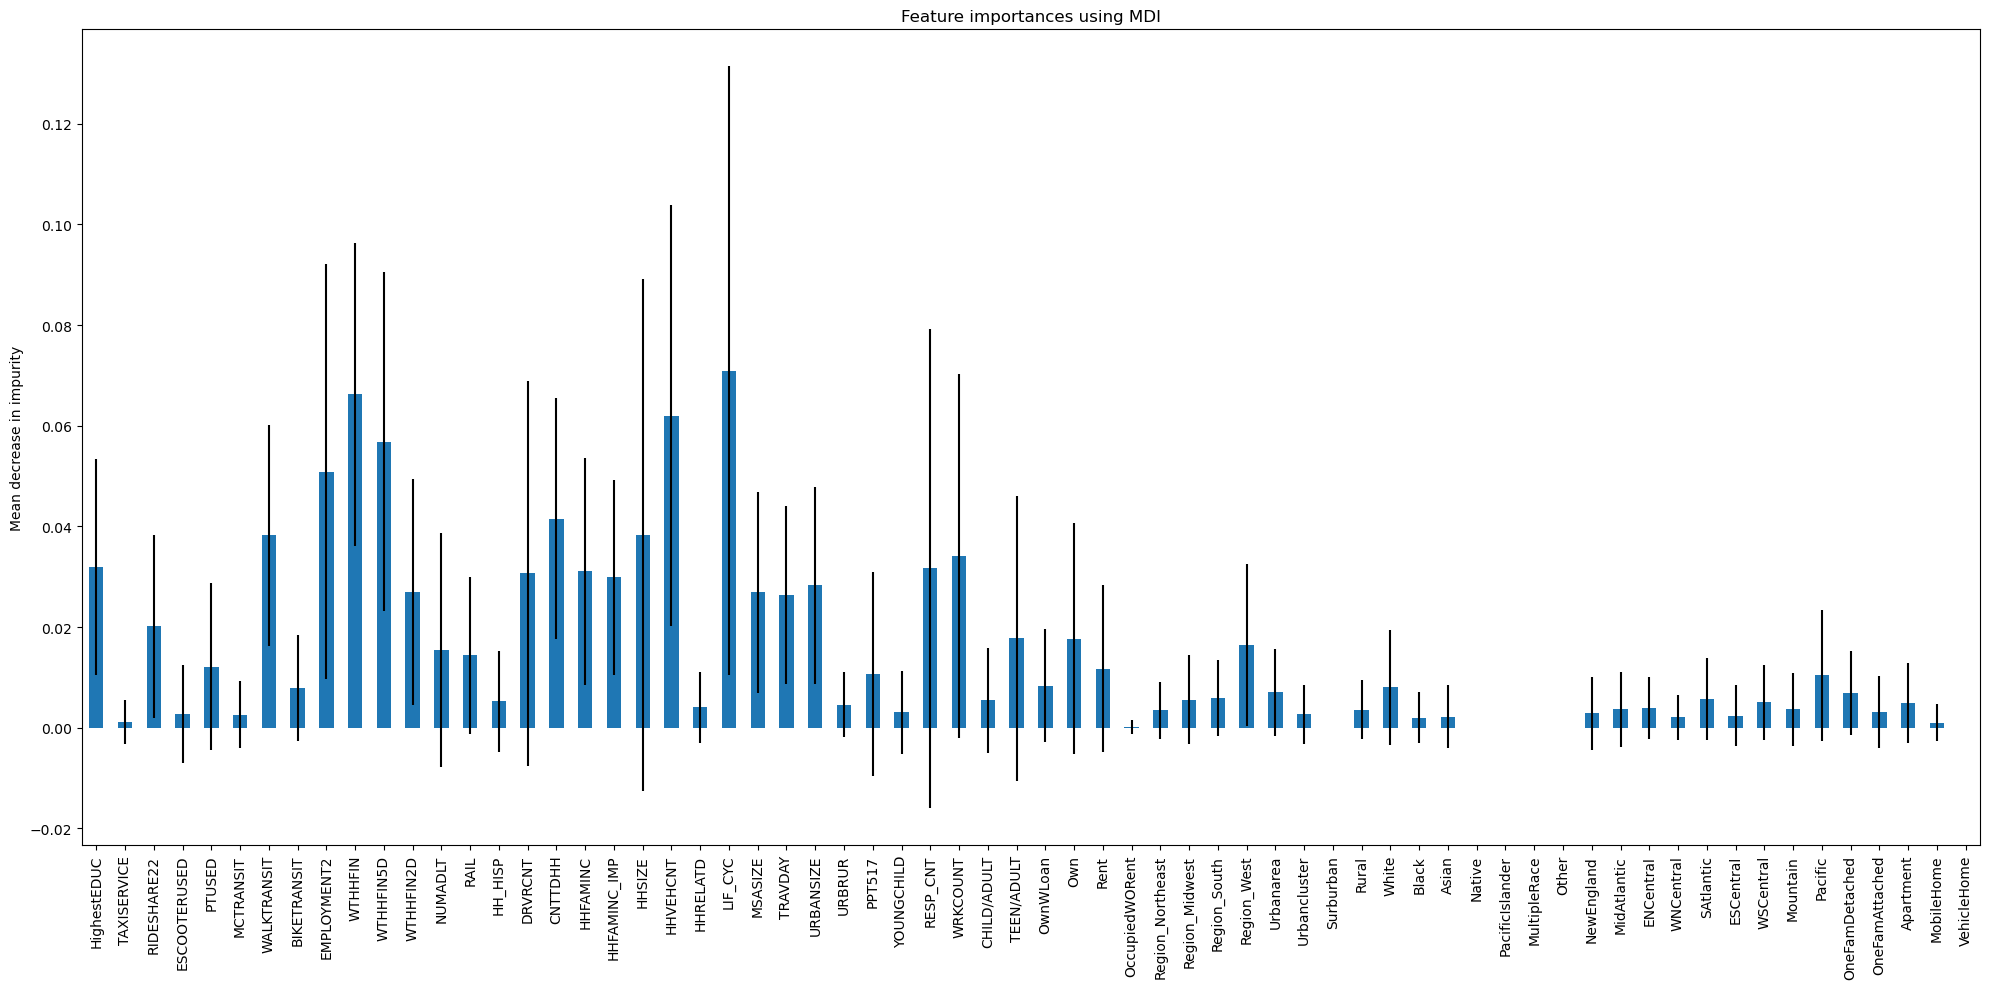

In [591]:
importances = pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_)
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

forest_importances = pd.Series(importances, index=rfc.feature_names_in_)
fig, ax = plt.subplots(figsize=(20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [592]:
result = permutation_importance(
    rfc, x_test, y_test, n_repeats=10, random_state=None, n_jobs=None
)
forest_importances = pd.Series(result.importances_mean, index=rfc.feature_names_in_)

fig, ax = plt.subplots(figsize=(20,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

KeyboardInterrupt: 